In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import torch
import faiss
import os
from tqdm.notebook import tqdm

### Load movie database

In [2]:
# Load movie database
movie_db = pd.read_csv('data/movies.csv').rename(columns=lambda x: x.strip().replace(" ", ""))

### Clean data

In [3]:
# Process movie database
def clean_column(text):
    """Removes Wikipedia markup, unnecessary tags, and extracts names."""
    if pd.isna(text) or text.lower() == "none":
        return "Unknown"
    
    # Remove Wikipedia templates, comments, and unnecessary symbols
    text = re.sub(r"\{\{.*?\}\}", "", text)  # Remove Wikipedia template tags
    text = re.sub(r"<!--.*?-->", "", text)  # Remove HTML comments
    text = re.sub(r"\[\[(?:[^\]|]*\|)?([^\]]+)\]\]", r"\1", text)  # Extract names from Wikipedia links
    text = re.sub(r"\*", "", text)  # Remove asterisks used for listing
    
    return text.strip()

In [4]:
def extract_actors(text):
    """Extract actors from the cast column."""
    if pd.isna(text) or text.lower() == "none" or text.lower() == "unknown":
        return ""
    actors = ", ".join(re.findall(r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\s+as", text))
    if actors == "":
        return text
    else:
        return actors

In [5]:
# Remove markup from cast and plot column
movie_db["cast"] = movie_db["cast"].apply(clean_column)
movie_db["plot"] = movie_db["plot"].apply(clean_column)

In [6]:
# Get the actors list
movie_db["actors"] = movie_db["cast"].apply(extract_actors)

### Load LLM model

In [7]:
# Load LLM model
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

Using device: mps


### Create vector embedding based on movie plot

In [8]:
# Create embeddings based on plot
if os.path.exists('data/faiss_movie_index.all-mpnet-base-v2'):
    print("Loading existing index...")
    index = faiss.read_index('data/faiss_movie_index.all-mpnet-base-v2')
    print(f"Index size: {index.ntotal}")
else:
    print("Creating new index...")
    embeddings = model.encode(movie_db['plot'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    movie_db['embedding'] = [emb.cpu().numpy() for emb in embeddings] 

    # Save the embeddings and metadata to local disk
    embeddings_np = np.stack(movie_db['embedding']).astype('float32')
    dimension = embeddings_np.shape[1]  # 768
    print(f"Embeddings shape: {embeddings_np.shape}, dimension: {dimension}")
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings_np)
    faiss.write_index(index, 'data/faiss_movie_index.all-mpnet-base-v2')
    print("Index and metadata saved.")

Loading existing index...
Index size: 15795


In [9]:
# Get embedding for the given text
def get_embedding_llm(text):
    """Get the LLM embedding for the given text."""
    return model.encode(text, convert_to_tensor=True).cpu().numpy()

In [10]:
# Get similar movies given a movie title
def get_recommendations_from_title_llm(title, model, movies=movie_db, top_n=10):
    # Get the index of the movie that matches the title
    print("matching title", title)
    idx = movie_db[movie_db['title'].str.contains(rf"\b{title}\b", case=False, na=False, regex=True)].index[0]
    print("idx", idx)
    
    plot_text = movie_db['plot'].iloc[idx].lower()
    print("title = ", movie_db.iloc[idx]['title'])
    print("plot = ", plot_text)
    
    user_embedding = get_embedding_llm(plot_text)
    distances, indices = index.search(np.array([user_embedding]).astype('float32'), k=top_n)
        
    # Return the titles of recommended movies
    return movie_db.iloc[indices[0]][['title', 'poster']]

In [11]:
# Get movie recommendation from movie plot
def get_recommendations_from_plot_llm(plot_text, model, movies=movie_db, top_n=10):
    user_embedding = get_embedding_llm(plot_text)
    distances, indices = index.search(np.array([user_embedding]).astype('float32'), k=top_n)
        
    # Return the titles of recommended movies
    return movie_db.iloc[indices[0]][['title', 'poster']]

In [76]:
# Display images in a grid
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt

def display_images(df, cols=2, img_size=(200, 300)):
    rows = (len(df) + cols - 1) // cols  # Compute required rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 4))
    fig.patch.set_facecolor("black")  # Set figure background color
    axes = axes.flatten()  # Flatten in case of excess subplots

    for ax, (title, img_url) in zip(axes, zip(df["title"], df["poster"])):
        ax.set_title(title, fontsize=10, color="white")
        ax.axis("off")
        try:
            # print(img_url)
            response = requests.get(img_url)
            if response.status_code != 200:
                response = requests.get(img_url)

            img = Image.open(BytesIO(response.content))
            img = img.resize(img_size)

            ax.imshow(img)
        except Exception as e:
            print(f"Error loading image: {e}")
            img = Image.open("images/no_image.png").resize(img_size)
            ax.imshow(img)
            continue

    # Hide unused subplots
    for ax in axes[len(df):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Test the LLM based recommendation system with input as movie name

matching title Aliens
idx 200
title =  Aliens (film)
plot =  ellen ripley has been in stasis for 57 years aboard an escape shuttle after destroying her ship  the ''nostromo''  to escape an alien creature that slaughtered the rest of the crew. she is rescued and debriefed by her employers at the weyland-yutani corporation  who are skeptical about her claim of alien eggs in a derelict ship on the exomoon lv-426  since it is now the site of a terraforming colony.after contact is lost with the colony  weyland-yutani representative carter burke and colonial marine lieutenant gorman ask ripley to accompany them to investigate. still traumatized by her alien encounter  she agrees on the condition that they exterminate the creatures. ripley is introduced to the colonial marines on the spaceship ''sulaco'' but is distrustful of their android  bishop  because the android aboard the ''nostromo'' betrayed its crew to protect the alien on company orders.a dropship delivers the expedition to the sur

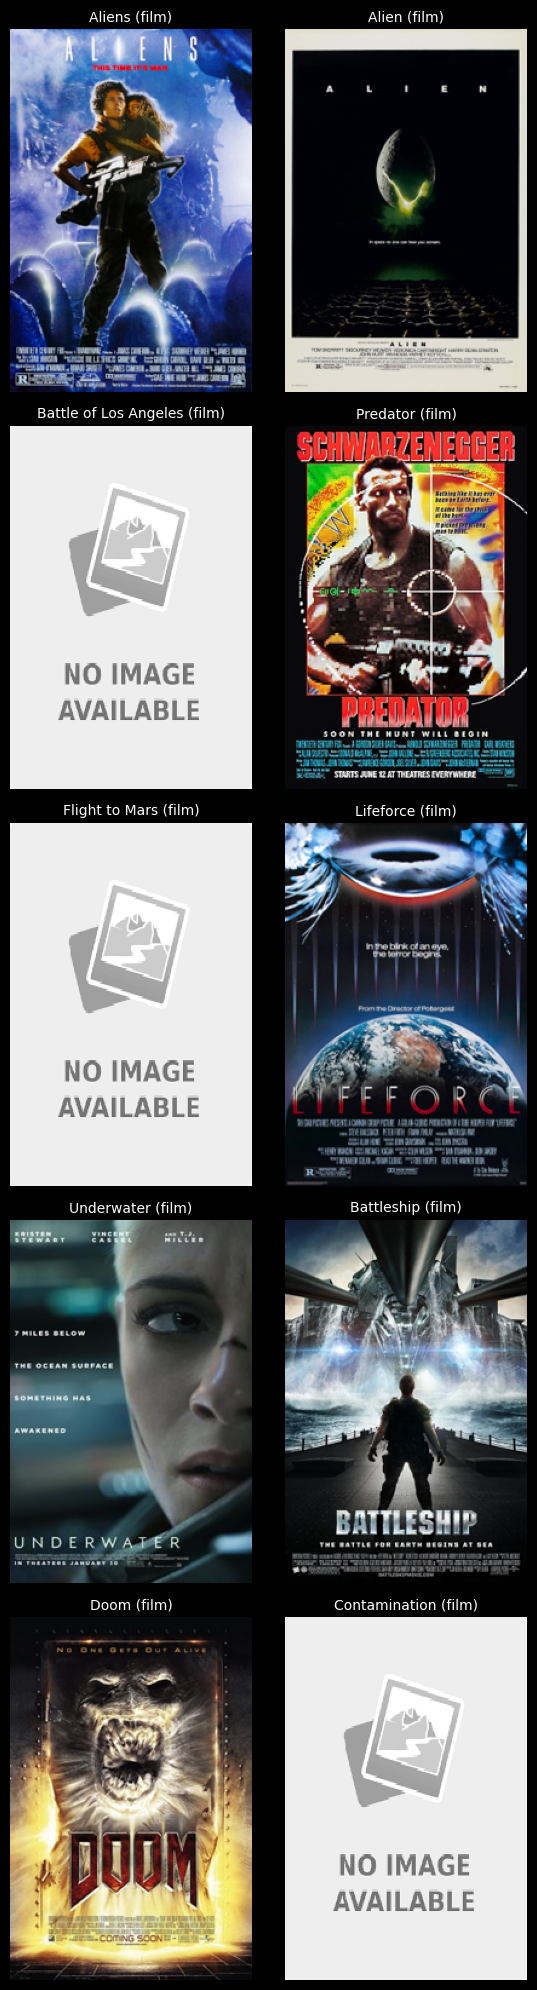

In [14]:
# Test the LLM based recommendation system for a movie name
movie_title = input("Enter a movie title: ")
recommendations = get_recommendations_from_title_llm(movie_title, model, movie_db, 10)
print(f"Recommendations for '{movie_title}':")
print(recommendations)

# Display posters
display_images(recommendations)

### Test the LLM based recommendation system for a movie plot

Recommendations for plot: 'comedy of high school boys':
                           title  \
10880          Class Rank (film)   
4754            Chat Room (film)   
10683           Photocopy (film)   
14477           Supercool (film)   
3053        American Teen (film)   
12841             Rip-Off (film)   
7724        21 &amp; Over (film)   
8867       Geography Club (film)   
8838               G.B.F. (film)   
346    Dazed and Confused (film)   

                                                  poster  
10880  https://upload.wikimedia.org/wikipedia/en/d/df...  
4754   https://upload.wikimedia.org/wikipedia/en/b/b1...  
10683  https://upload.wikimedia.org/wikipedia/en/7/78...  
14477  https://upload.wikimedia.org/wikipedia/en/2/29...  
3053   https://upload.wikimedia.org/wikipedia/en/d/dd...  
12841  https://upload.wikimedia.org/wikipedia/en/e/e6...  
7724   https://upload.wikimedia.org/wikipedia/en/2/22...  
8867   https://upload.wikimedia.org/wikipedia/en/5/5d...  
8838   https://u

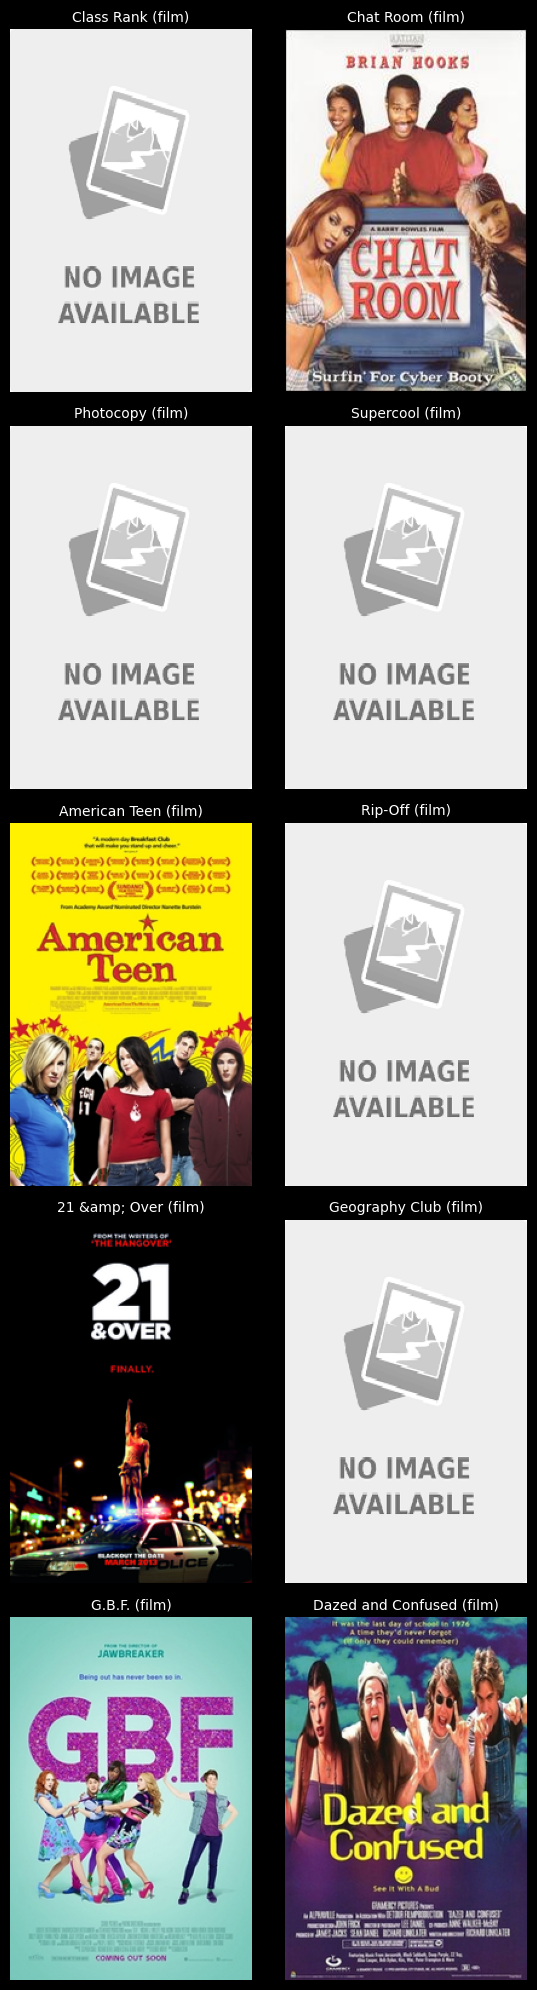

In [16]:
# Test the LLM based recommendation system for a movie plot
default_plot_text = "movies about a wizard with dangerous powers"
plot_text = input(f"Enter a movie plot:")
recommendations = get_recommendations_from_plot_llm(plot_text, model, movie_db, 10)
print(f"Recommendations for plot: '{plot_text}':")
print(recommendations)

# Display posters
display_images(recommendations)

### Films by an actor

In [8]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree

In [15]:
# Download required NLTK datasets (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
print(nltk.data.path)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...


['/Users/mahadevgaonkar/nltk_data', '/opt/miniconda3/envs/berkeley_ai/nltk_data', '/opt/miniconda3/envs/berkeley_ai/share/nltk_data', '/opt/miniconda3/envs/berkeley_ai/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [47]:
# Function to extract names
def extract_actor_names(text):
    # Tokenize and tag parts of speech
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    
    # Extract proper nouns (NNP - singular or compound proper noun)
    actor_names = []
    i = 0
    while i < len(tagged_words):
        if tagged_words[i][1] == "NNP":
            name = tagged_words[i][0]
            i += 1
            # Check if the next word is also a proper noun (for full names)
            if i < len(tagged_words) and tagged_words[i][1] == "NNP":
                name += " " + tagged_words[i][0]
            actor_names.append(name)
        i += 1
    
    return actor_names

Extracted actors: ['Sylvester Stallone', 'Woody Allen']
Error loading image: cannot identify image file <_io.BytesIO object at 0x33e399580>
Error loading image: cannot identify image file <_io.BytesIO object at 0x33e39ac50>


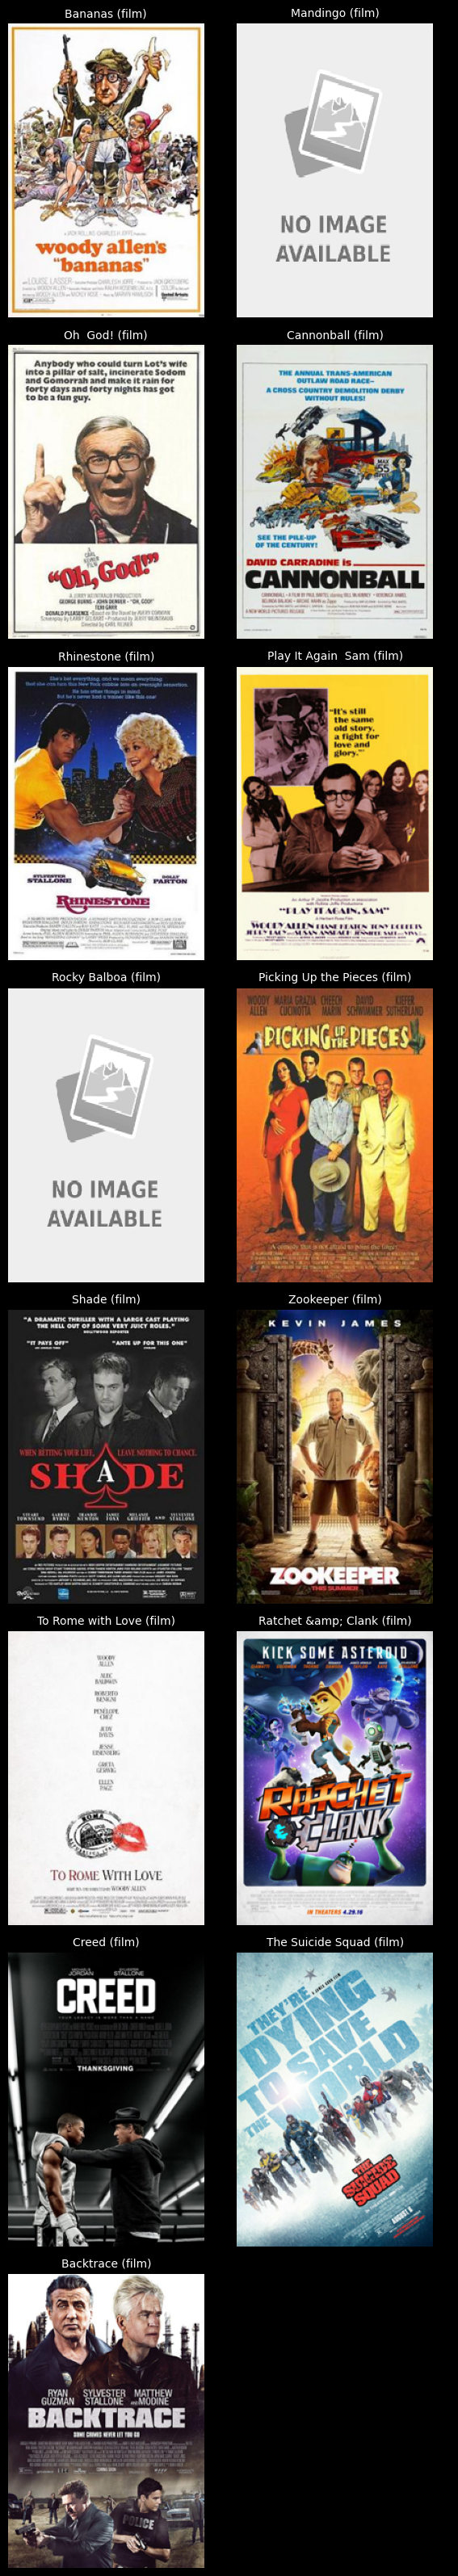

In [102]:
actor_text = "films having Sylvester Stallone, Woody Allen."
actors = extract_actor_names(actor_text)
print(f"Extracted actors: {actors}")
movies = movie_db[movie_db['cast'].str.contains('|'.join(actors), case=False, na=False, regex=True)]

# Display 20 movies with the extracted actors
if movies.empty:
    print("No movies found for the given actor.")
else:
    display_images(movies.head(20))


Extracted actors: ['Tom Cruise']


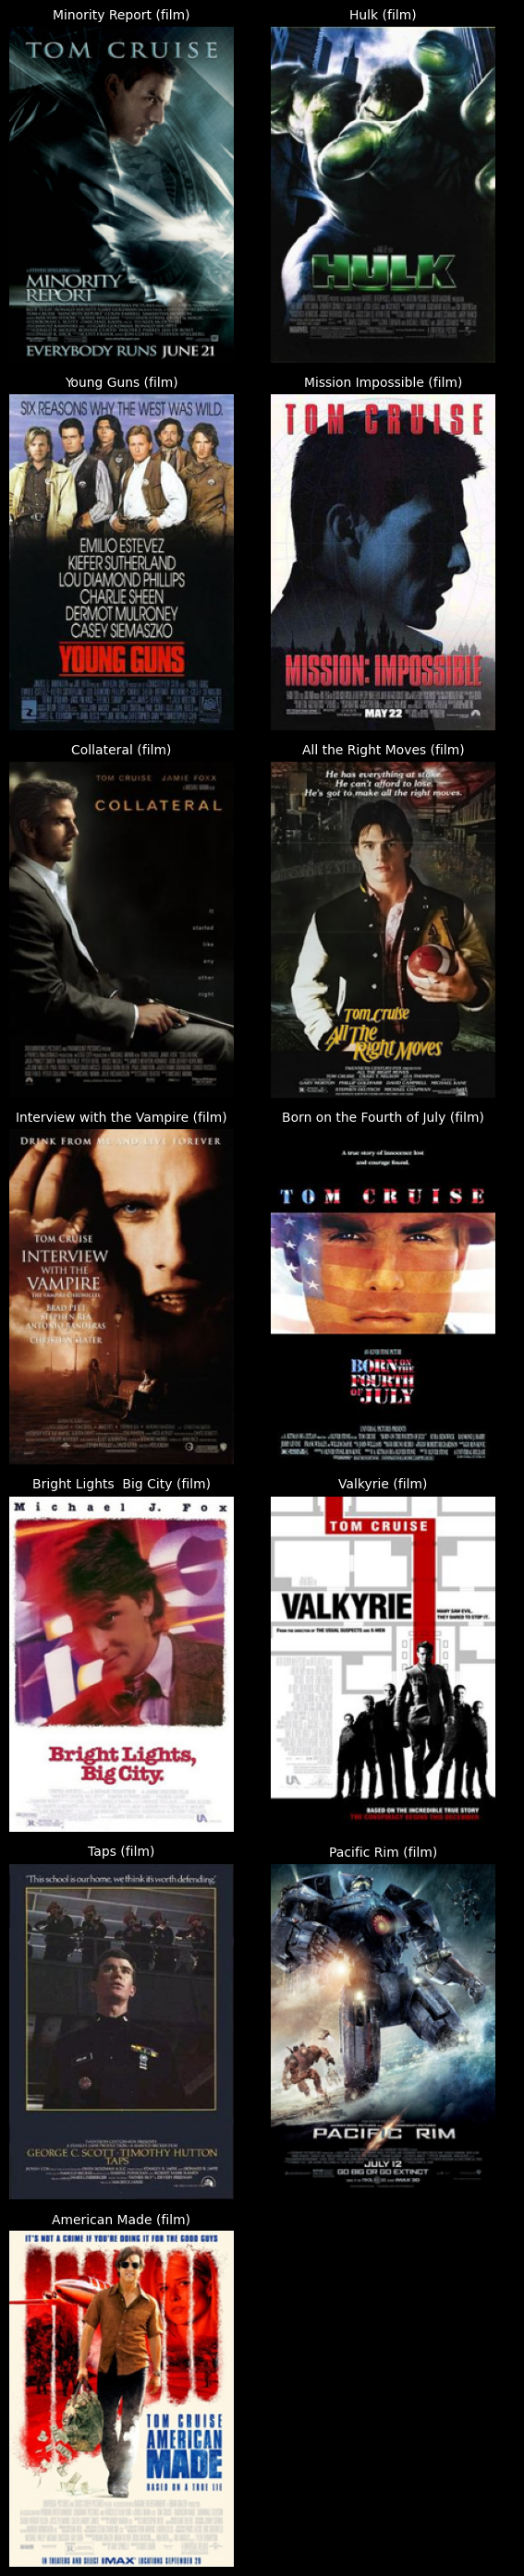

In [103]:
actor_text = "films having Tom Cruise."
actors = extract_actor_names(actor_text)
print(f"Extracted actors: {actors}")
movies = movie_db[movie_db['cast'].str.contains('|'.join(actors), case=False, na=False, regex=True)]
if movies.empty:
    print("No movies found for the given actor.")
else:
    display_images(movies.head(20))